In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix

# 0. Load datasets

In [2]:
datasets_path = lambda  file_name: f'/Users/stijnvanleeuwen/Desktop/codes/EUR/Ass2/datasets/{file_name}.parquet'

baskets = pd.read_parquet(datasets_path('baskets')).astype({'week':'uint8', 'customer':'category','product':'category', 'price':'uint16'}) 
coupons = pd.read_parquet(datasets_path('coupons')).astype({'week':'uint8', 'customer':'category','product':'category', 'discount':'uint8'})
prediction_index = pd.read_parquet(datasets_path('prediction_index')).astype({'week':'uint8', 'customer':'category','product':'category'}) 

# 1. Create base dataframe 

In [ ]:
weeks = range(0,88+1)
customers = range(1000,2000)
products = range(250)

n_weeks, n_customers, n_products = len(weeks), len(customers), len(products)

base = pd.DataFrame()

base['week'] =     np.array([[x] * n_products * n_customers for x in weeks]).flatten()
base['customer'] = np.array([[x] * n_products * n_weeks for x in customers]).flatten()
base['product'] =  np.array([[x] * n_weeks * n_customers for x in products]).flatten()

base = pd.merge(base, baskets, on=['week', 'customer','product'], how='left')

base['price'] = base['price'].fillna(0).astype('uint16')
base['bought'] = (base['price']!=0).astype(int)

Error: Session cannot generate requests

In [ ]:
#One-hot encoding product and dummy iDs as they should not be seen as numerical but as categorical 
base2 = pd.get_dummies(base)

# 2. Split into train & test

In [ ]:
train = base2[base2['week']!=88]
test =  base2[base2['week']==88]

x_train, x_test = train.drop(['price','bought'],axis=1), test.drop(['price','bought'],axis=1)
y_train, y_test = train['bought'], test['bought']

Error: Session cannot generate requests

In [ ]:
y_test.mean()

0.0

# 3. Random Forest Classification

In [ ]:
# a. Train model
model = DecisionTreeClassifier(max_leaf_nodes=1000, random_state=42)
model.fit(x_train, y_train)

DecisionTreeClassifier(max_leaf_nodes=1000, random_state=42)

<IPython.core.display.Javascript object>

[Text(5195.379644588045, 3159.6749999999997, 'product_49 <= 0.5\ngini = 0.078\nsamples = 2200000\nvalue = [2110300, 89700]'),
 Text(5003.069466882068, 2955.825, 'product_40 <= 0.5\ngini = 0.071\nsamples = 2191100\nvalue = [2110300, 80800]'),
 Text(4810.7592891760905, 2751.975, 'product_79 <= 0.5\ngini = 0.064\nsamples = 2182200\nvalue = [2110300, 71900]'),
 Text(4618.449111470113, 2548.125, 'product_170 <= 0.5\ngini = 0.056\nsamples = 2173300\nvalue = [2110300, 63000]'),
 Text(4426.138933764136, 2344.275, 'product_116 <= 0.5\ngini = 0.049\nsamples = 2164400\nvalue = [2110300, 54100]'),
 Text(4233.828756058158, 2140.425, 'product_90 <= 0.5\ngini = 0.041\nsamples = 2155500\nvalue = [2110300, 45200]'),
 Text(4041.518578352181, 1936.575, 'product_235 <= 0.5\ngini = 0.033\nsamples = 2146600\nvalue = [2110300, 36300]'),
 Text(3467.592891760905, 1732.725, 'product_61 <= 0.5\ngini = 0.026\nsamples = 2137700\nvalue = [2109900, 27800]'),
 Text(2896.6720516962846, 1528.875, 'product_199 <= 0.5\ng

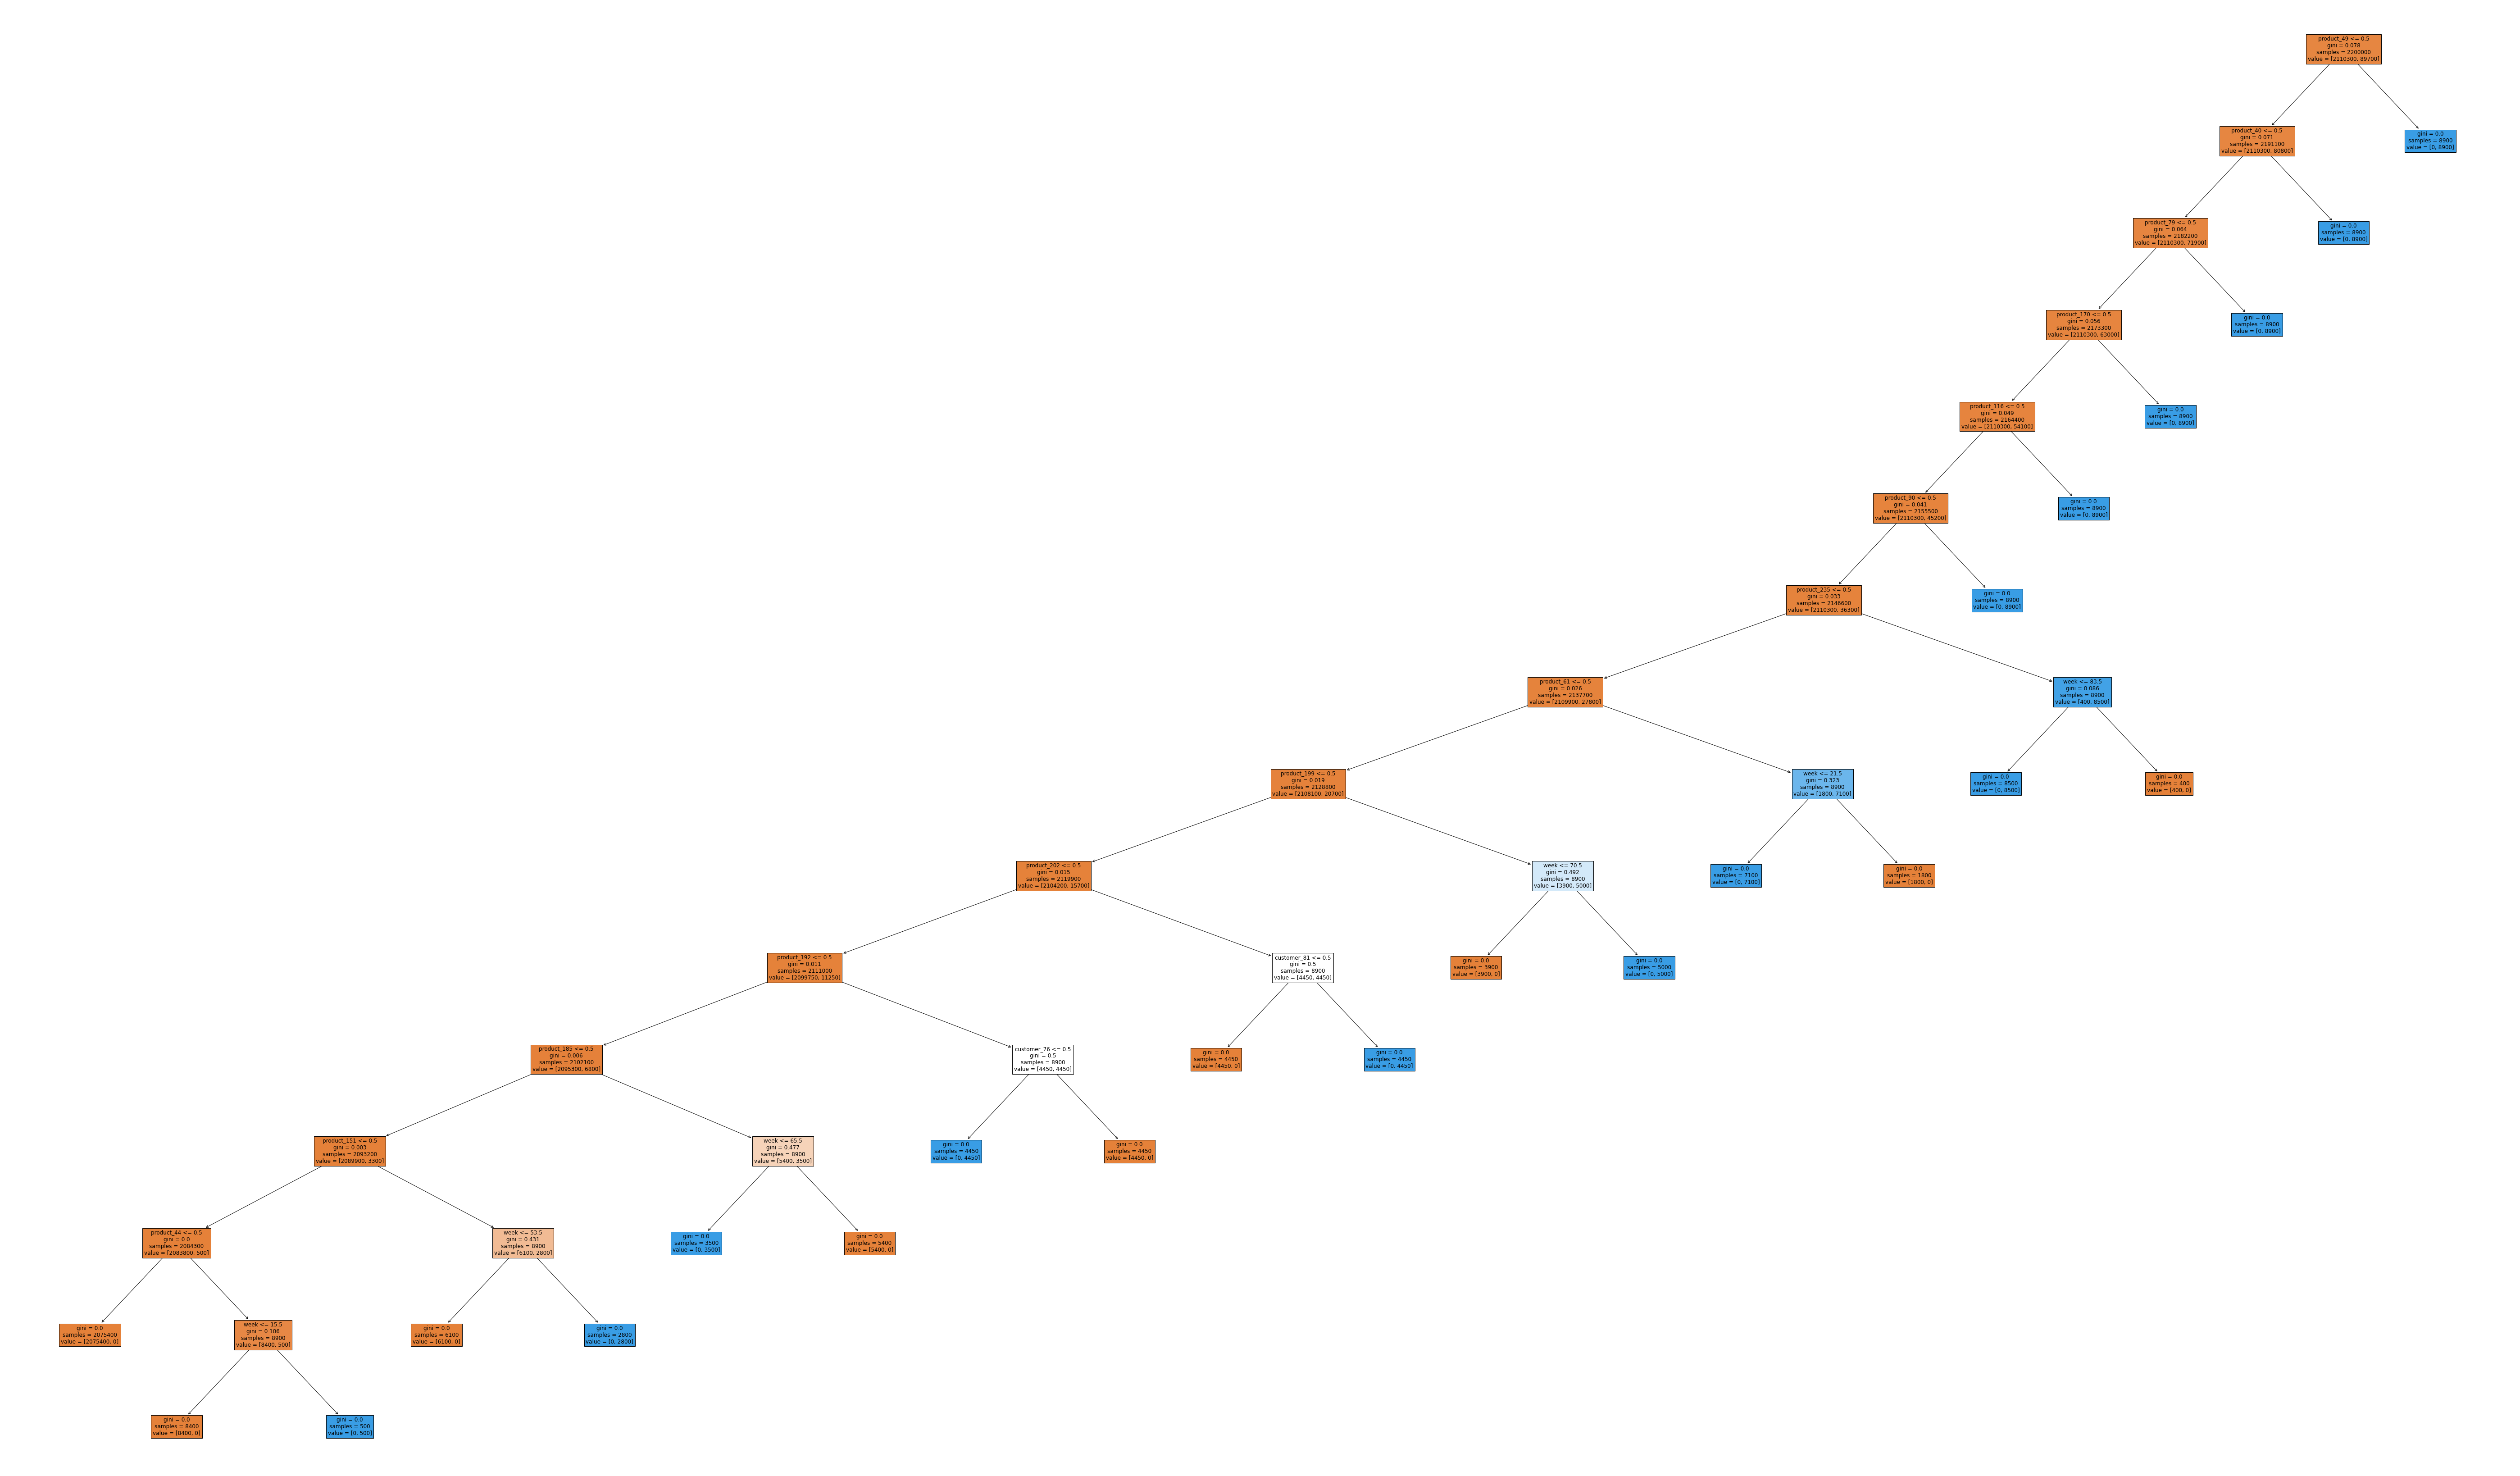

In [ ]:
plt.figure(figsize=(100,60))
tree.plot_tree(model,fontsize=12, filled=1, feature_names=list(x_train.columns))

In [ ]:
# b. Predict y on test
y_pred = model.predict(x_test)
y_pred.mean()

0.0

In [ ]:
# c. Get confusion matrix
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25000

    accuracy                           1.00     25000
   macro avg       1.00      1.00      1.00     25000
weighted avg       1.00      1.00      1.00     25000



In [ ]:
y_test.mean()

0.0

In [ ]:
metrics.precision_score(y_test,y_pred)

<IPython.core.display.Javascript object>

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0